In [1]:
import sys
sys.path.append('../../..')

from olfactory_navigation import Environment
from olfactory_navigation.agents import FSVI_Agent
from olfactory_navigation.simulation import run_test

from olfactory_navigation.agents.model_based_util.pomdp import Model
from olfactory_navigation.agents.model_based_util.belief import Belief, BeliefSet
from olfactory_navigation.environment import _resize_array
from viz import plot_trajectory_in_tank

from matplotlib import pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from datetime import datetime

import pandas as pd
import numpy as np
import h5py
import os

In [2]:
from cupy.cuda import runtime as cuda_runtime
cuda_runtime.setDevice(3)

## Parameters

In [3]:
agent_speed = 4 # cm/s
dt = 0.5 # s
multiplier = agent_speed * dt
actual_tank_size = np.array([90,114]) # actual size: 90cm x 114cm but it is scaled by a walking speed of <multiplier>
tank_size = (actual_tank_size / multiplier).astype(int)
space_shape = (tank_size * 2) + 1

source_position = tank_size

goal_radius = 1
# odor_radius = 10.5
odor_radius = 3 / multiplier # 3 cm * 0.8 -> 3.75 grid units

In [4]:
# Odor variables
thresh_scale = 5
thresh = 3 / 10**(thresh_scale)

base_odor_plume_file = f'../plume_average_computation/average_odor_base_3e{thresh_scale}.npy'
odor_fields_folder = '/storage/arnaud/tank_odor_field_2024_06_13/'
test_result_folder = f'./results-thresh_3e{thresh_scale}-{datetime.now().strftime("%Y%m%d_%H%M%S")}/'

## Building POMDP Model

In [5]:
# Legs odor field
odor_field = np.zeros(space_shape)
odor_field_indices = np.array(list(np.ndindex(tuple(space_shape))))

in_odor_plume = np.sum((odor_field_indices - tank_size[None,:])**2, axis=1) <= (odor_radius ** 2)
odor_field[*odor_field_indices[in_odor_plume].T] = 1.0

In [6]:
# Gathering nose odor plume
average_odor_plume = np.load(base_odor_plume_file)

odor_shape = np.array([408, 488])
odor_center = np.array([500, 500])

lower_bound = odor_center - (odor_shape / 2).astype(int)
upper_bound = odor_center + (odor_shape / 2).astype(int)
slices = [slice(lb, ub) for lb, ub in zip(lower_bound, upper_bound)]

average_odor_plume = average_odor_plume[*slices]

assert all(average_odor_plume.shape == odor_shape)

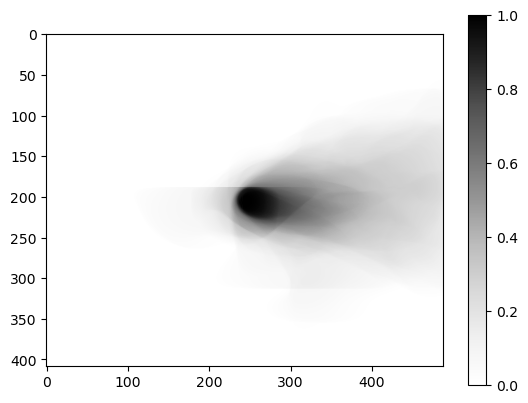

In [7]:
plt.imshow(average_odor_plume, cmap='Greys')
plt.colorbar()
plt.show()

In [8]:
# Nose odor field
tank_average_odor_plume = _resize_array(average_odor_plume, tank_size, 'linear')

# Putting odor plume average in
nose_odor_field = np.zeros(odor_field.shape)
lower_bounds, upper_bounds = (tank_size/2).astype(int), (tank_size/2).astype(int) + tank_size
nose_odor_field[*[slice(lb, ub) for lb, ub in zip(lower_bounds, upper_bounds)]] = tank_average_odor_plume

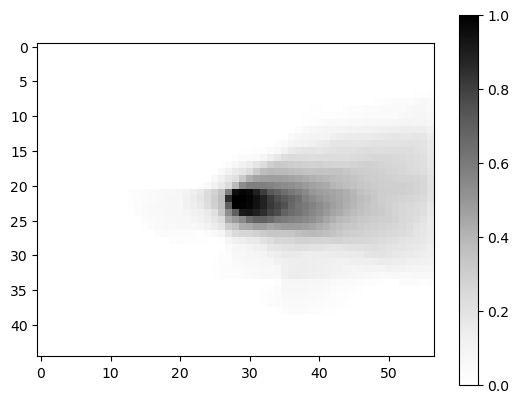

In [9]:
plt.imshow(tank_average_odor_plume, cmap='Greys')
plt.colorbar()
plt.show()

In [10]:
thresholds = np.array([-np.inf,1,2,np.inf])
action_set = np.array([
    [-1,  0], # North
    [ 0,  1], # East
    [ 1,  0], # South
    [ 0, -1]  # West
])
action_labels = [
    'North',
    'East',
    'South',
    'West'
]

In [11]:
# Base Model parameters
state_count = np.prod(space_shape)

state_grid = [[f's_{x}_{y}' for x in range(space_shape[1])] for y in range(space_shape[0])]
end_states = np.argwhere(np.fromfunction(lambda x,y: ((x-source_position[0])**2 + (y-source_position[1])**2) <= goal_radius**2,
                                            shape=space_shape).ravel())[:,0].tolist()

# Counts
action_count = len(action_set)
observation_count = thresholds.shape[-1] # Thresholds minus 1; plus 1 for the goal.

# Building observation matrix
observations = np.empty((state_count, action_count, observation_count), dtype=float)

filt_nose_odor_field = nose_odor_field.ravel()
filt_nose_odor_field[odor_field.ravel() > 0.0] = 0.0

observations[:,:,1] = filt_nose_odor_field[:,None] # Nose
observations[:,:,2] = odor_field.ravel()[:,None] # Nose AND legs
observations[:,:,0] = 1.0 - observations[:,:,1] - observations[:,:,2] # Nothing

# Goal observation
observations[:,:,-1] = 0.0
observations[end_states,:,:] = 0.0
observations[end_states,:,-1] = 1.0

# Assert observations sum to 1
assert np.all(np.sum(observations, axis=2) == 1.0), "Observation table malformed, something is wrong..."

# Observation labels
observation_labels = ['nothing', 'something_nose', 'something_nose_legs', 'goal']

# Compute reachable states
points = np.array(np.unravel_index(np.arange(np.prod(space_shape)), space_shape)).T

# For each actions compute all new grid points (using the environment.move method)
action_new_states = []
movements = action_set
for move_vector in movements:

    # Applying the movement vector
    new_points = points + move_vector

    # Wrap points
    new_points = np.where(new_points < 0, (new_points + space_shape[None,:]), new_points)
    new_points = np.where(new_points >= space_shape[None,:], (new_points - space_shape[None,:]), new_points)

    new_states = np.ravel_multi_index((new_points[:,0], new_points[:,1]), dims=space_shape)
    action_new_states.append(new_states)

# Forming it the reachable states array from the new states for each action
reachable_states = np.array(action_new_states).T[:,:,None]

# Instantiate the model object
model = Model(
    states = state_grid,
    actions = action_labels,
    observations = observation_labels,
    reachable_states = reachable_states,
    observation_table = observations,
    end_states = end_states
)

## Building Environment

In [12]:
odor_field_files = os.listdir(odor_fields_folder)
odor_field_environments = []
odor_field_source_pos = []

for file_i, file in enumerate(odor_field_files):
    print(f'[{file_i+1}/{len(odor_field_files)}] Loading odor field: {odor_fields_folder}{file}')

    # Loading data
    data = h5py.File(odor_fields_folder + file, 'r')

    # Finding out start and end times
    time_slices = data['odor_base']
    time_slices = sorted([int(key_name) for key_name in time_slices.keys()])

    start_time = min(time_slices)
    end_time = max(time_slices)

    # Gathering data
    odor = data['odor_base']
    odor_data = [odor[str(time)] for time in range(start_time, end_time)]
    odor_data_array = np.array(odor_data)

    # Resizing the data array
    new_odor_data_array = np.zeros((len(odor_data_array), *tank_size))
    for i, data_slice in enumerate(odor_data_array):
        new_odor_data_array[i] = _resize_array(data_slice,
                                               new_shape=tank_size,
                                               interpolation='linear')

    # compute the odor source position
    source_pos = np.unravel_index(np.argmax(new_odor_data_array[0]), shape=new_odor_data_array[0].shape)

    # Centering the odor field
    centered_odor_data_array = np.zeros((len(odor_data_array), *space_shape))
    for i, data_slice in enumerate(new_odor_data_array):
        centered_odor_data_array[i,
                                (tank_size[0] - source_pos[0]) : (tank_size[0] - source_pos[0] + tank_size[0]),
                                (tank_size[1] - source_pos[1]) : (tank_size[1] - source_pos[1] + tank_size[1])] = data_slice

    # Filtering the odor field
    filt_odor_data_array = (centered_odor_data_array > thresh).astype(float)

    legs_odor = np.argwhere(odor_field > 0)
    for i in range(len(filt_odor_data_array)):
        filt_odor_data_array[i,*legs_odor.T] = 2.0

    # Setting up environment
    env = Environment(data_file = filt_odor_data_array,
                      data_source_position = tank_size,
                      source_radius = goal_radius,
                      boundary_condition = 'wrap')

    # Saving environment and source positions
    odor_field_environments.append(env)
    odor_field_source_pos.append(np.array(source_pos) / np.array(new_odor_data_array.shape[1:]))

[1/12] Loading odor field: /storage/arnaud/tank_odor_field_2024_06_13/35_75.h5
[2/12] Loading odor field: /storage/arnaud/tank_odor_field_2024_06_13/65_75.h5
[3/12] Loading odor field: /storage/arnaud/tank_odor_field_2024_06_13/35_35.h5
[4/12] Loading odor field: /storage/arnaud/tank_odor_field_2024_06_13/45_5.h5
[5/12] Loading odor field: /storage/arnaud/tank_odor_field_2024_06_13/45_35.h5
[6/12] Loading odor field: /storage/arnaud/tank_odor_field_2024_06_13/25_65.h5
[7/12] Loading odor field: /storage/arnaud/tank_odor_field_2024_06_13/55_45.h5
[8/12] Loading odor field: /storage/arnaud/tank_odor_field_2024_06_13/20_65.h5
[9/12] Loading odor field: /storage/arnaud/tank_odor_field_2024_06_13/25_55.h5
[10/12] Loading odor field: /storage/arnaud/tank_odor_field_2024_06_13/15_45.h5
[11/12] Loading odor field: /storage/arnaud/tank_odor_field_2024_06_13/15_5.h5
[12/12] Loading odor field: /storage/arnaud/tank_odor_field_2024_06_13/55_25.h5


## Agent Training

In [13]:
ag = FSVI_Agent(odor_field_environments[0],
                model=model,
                thresholds=[-np.inf, 1.0, 2.0, np.inf])

In [14]:
_ = ag.train(expansions=800,
             max_belief_growth=100,
             eps=1e-8,
             use_gpu=True)

[12/20/2024, 16:57:32] MDP_policy, not provided. Solving MDP with Value Iteration...
[12/20/2024, 16:57:32] Sending Model to GPU...
[12/20/2024, 16:57:33]     > Done in 0.178s


  0%|          | 0/1000 [00:00<?, ?it/s]

Summary of Value Iteration run
  - Model: 10465-state, 4-action
  - Converged in 1000 iterations and 0.8035 seconds
  - Took on average 0.0008s per iteration


Expansions:   0%|          | 0/800 [00:00<?, ?it/s]

Memory full: Out of memory allocating 22,170,395,648 bytes (allocated so far: 68,900,254,720 bytes).
Returning value function and history as is...

Summary of Point Based Value Iteration run
  - Model: 10465 state, 4 action, 4 observations
  - Converged or stopped after 446 expansion steps and 445 backup steps.
  - Resulting value function has 16551 alpha vectors.
  - Converged in 282.4025s

  - Expand function took on average 0.0789s and yielded on average 7872.03 beliefs per iteration. (0.0000s/it/belief)
  - Backup function took on average 0.5556s and yielded on average 37.18 alpha vectors per iteration. (0.0002s/it/alpha)
  - Pruning function took on average 0.0000s and yielded on average prunings of 0.00 alpha vectors per iteration.


[Warning] 'as_grid' parameter set to False but state count is >3 so it will be plotted as a grid


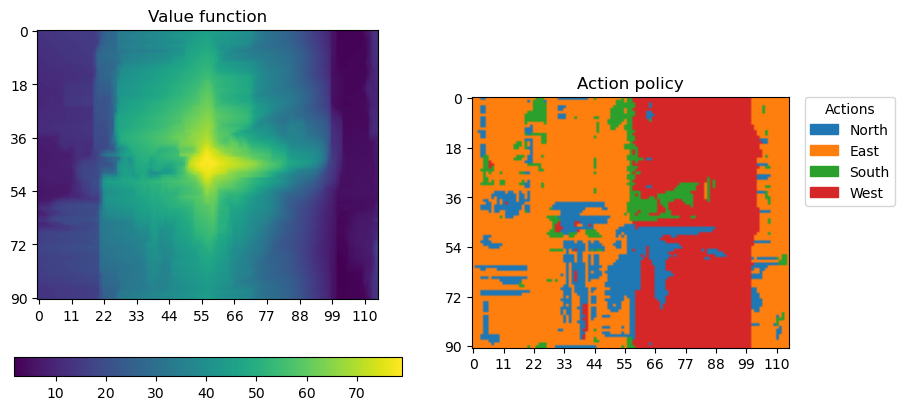

In [15]:
ag.value_function.plot()

## Run test

### Single point

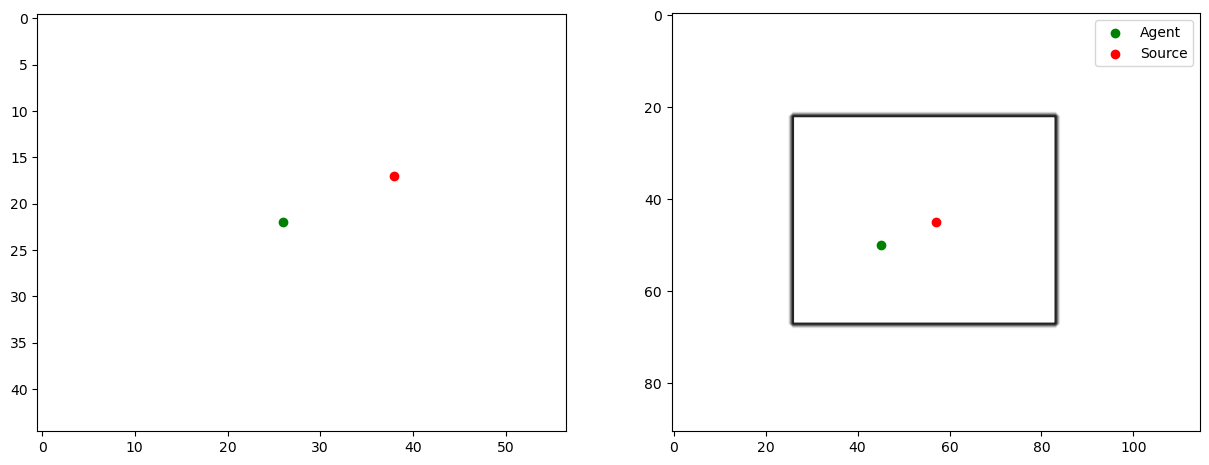

In [16]:
# PHYSICAL SPACE
source_point = (np.random.random(2) * tank_size).astype(int)
agent_start = (np.random.random(2) * tank_size).astype(int)

fig, (ax0,ax1) = plt.subplots(ncols=2, figsize=(15,10))

ax0.imshow(np.zeros(tank_size), cmap='Greys')
ax0.scatter(source_point[1], source_point[0], c='red', label='Source')
ax0.scatter(agent_start[1], agent_start[0], c='green', label='Agent')

# STATE SPACE
center_state = agent_start
agent_start_state = center_state + (tank_size - source_point)

belief = np.zeros(space_shape)
belief[center_state[0]:center_state[0]+tank_size[0]+1, center_state[1]:center_state[1]+tank_size[1]+1] = 1
belief /= np.sum(belief)

ax1.imshow(np.zeros(space_shape), cmap='Greys')
ax1.contour(belief, cmap='Greys')
# ax1.invert_yaxis()
ax1.scatter(agent_start_state[1], agent_start_state[0], c='green', label='Agent')
ax1.scatter(tank_size[1], tank_size[0], c='red', label='Source')
ax1.legend()

In [17]:
belief = BeliefSet(model=ag.model, beliefs=[Belief(model=ag.model, values=belief.ravel())])
hist = run_test(agent=ag,
                start_points=agent_start_state[None,:],
                initialization_values={'belief': belief},
                use_gpu=True)

Using the provided environment, not the agent environment.


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulations done in 4.145s:
Simulations reached goal: 0/1 (1 failures (reached horizon: 1)) (0.00% success)


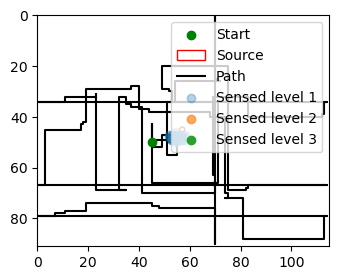

In [18]:
hist.plot()

### Experimental data

In [19]:
df = pd.read_csv('../experimental_data/experimental_positions.csv')

In [20]:
exp_source_indices = df[['y_food_cm','x_food_cm']].to_numpy().astype(float)
exp_agent_indices = df[['y0_cm', 'x0_cm']].to_numpy().astype(float)

exp_source_indices /= multiplier
exp_agent_indices /= multiplier

exp_source_indices = exp_source_indices.astype(int)
exp_agent_indices = exp_agent_indices.astype(int)

In [21]:
source_distances = []
odor_field_source_positions_in_tank = np.array(odor_field_source_pos) * tank_size

for source_pos in odor_field_source_positions_in_tank:
    source_distances.append(np.sum((exp_source_indices - source_pos) ** 2, axis=1) ** (1/2))

assigned_environment = np.argmin(np.array(source_distances), axis=0)

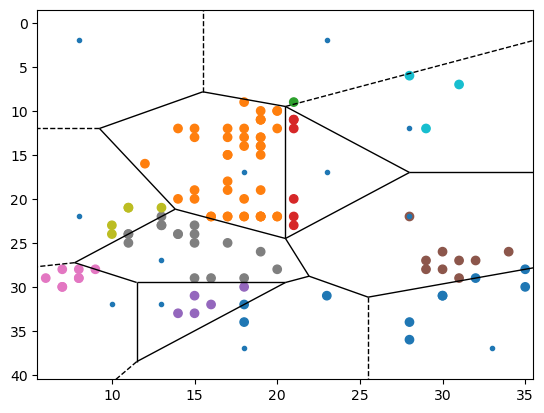

In [22]:
vor = Voronoi(odor_field_source_positions_in_tank[:,::-1])
fig = voronoi_plot_2d(vor, show_vertices=False)

plt.scatter(exp_source_indices[:,1], exp_source_indices[:,0], c=assigned_environment, cmap='tab10')
plt.gca().invert_yaxis()
plt.show()

In [23]:
# Generation of points
n = len(exp_source_indices)

# STATE SPACE
center_state = exp_agent_indices
agent_start_state = center_state + (tank_size[None,:] - exp_source_indices)

beliefs = []

for center, start in zip(center_state, agent_start_state):
    belief = np.zeros(space_shape)
    belief[center[0]:center[0]+tank_size[0]+1, center[1]:center[1]+tank_size[1]+1] = 1
    belief /= np.sum(belief)

    beliefs.append(belief.flatten())

beliefs = np.array(beliefs)

In [24]:
all_hist = None

source_ids = np.arange(len(exp_source_indices))
new_order_source_ids = []

for source_i, source_pos in enumerate(odor_field_source_positions_in_tank):
    print(f'[{source_i+1}/{len(odor_field_source_positions_in_tank)}] Environment {source_i}')

    # Checking which experimental source points have been assigned to the current environment
    is_assigned_model = (assigned_environment == source_i)
    env = odor_field_environments[source_i]
    new_order_source_ids += source_ids[is_assigned_model].tolist()

    # Skip if no experimental source point is assigned to the environment
    if np.sum(is_assigned_model) == 0:
        continue

    belief = BeliefSet(ag.model, beliefs[is_assigned_model])
    hist = run_test(agent=ag,
                    start_points=agent_start_state[is_assigned_model],
                    environment=env,
                    initialization_values={'belief': belief},
                    use_gpu=True,
                    print_stats=False)

    # Combine the history to the previous history instance
    if all_hist is None:
        all_hist = hist
    else:
        all_hist += hist

[1/12] Environment 0
Using the provided environment, not the agent environment.
Using the provided environment, not the agent environment.


  0%|          | 0/1000 [00:00<?, ?it/s]

[2/12] Environment 1
Using the provided environment, not the agent environment.
Using the provided environment, not the agent environment.


  0%|          | 0/1000 [00:00<?, ?it/s]

[3/12] Environment 2
Using the provided environment, not the agent environment.
Using the provided environment, not the agent environment.


  0%|          | 0/1000 [00:00<?, ?it/s]

[4/12] Environment 3
Using the provided environment, not the agent environment.
Using the provided environment, not the agent environment.


  0%|          | 0/1000 [00:00<?, ?it/s]

[5/12] Environment 4
Using the provided environment, not the agent environment.
Using the provided environment, not the agent environment.


  0%|          | 0/1000 [00:00<?, ?it/s]

[6/12] Environment 5
Using the provided environment, not the agent environment.
Using the provided environment, not the agent environment.


  0%|          | 0/1000 [00:00<?, ?it/s]

[7/12] Environment 6
Using the provided environment, not the agent environment.
Using the provided environment, not the agent environment.


  0%|          | 0/1000 [00:00<?, ?it/s]

[8/12] Environment 7
Using the provided environment, not the agent environment.
Using the provided environment, not the agent environment.


  0%|          | 0/1000 [00:00<?, ?it/s]

[9/12] Environment 8
Using the provided environment, not the agent environment.
Using the provided environment, not the agent environment.


  0%|          | 0/1000 [00:00<?, ?it/s]

[10/12] Environment 9
Using the provided environment, not the agent environment.
Using the provided environment, not the agent environment.


  0%|          | 0/1000 [00:00<?, ?it/s]

[11/12] Environment 10
[12/12] Environment 11
Using the provided environment, not the agent environment.
Using the provided environment, not the agent environment.


  0%|          | 0/1000 [00:00<?, ?it/s]

In [25]:
print(all_hist.summary)

Simulations reached goal: 117/118 (1 failures (reached horizon: 0)) (99.15% success)
 - Average step count:                 368.500 +- 188.81 (Successful only: 363.923 +- 183.77)
 - Extra steps:                        338.229 +- 189.32 (Successful only: 333.667 +- 184.35)
 - Average discounted rewards (ADR):   0.111 +- 0.22 (Successful only: 0.112 +- 0.22)
 - Tmin/T:                             0.165 +- 0.23 (Successful only: 0.166 +- 0.24)


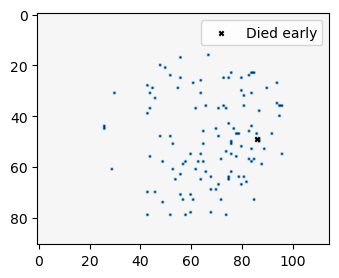

In [26]:
all_hist.plot_successes()

In [27]:
if not os.path.isdir(test_result_folder):
    os.mkdir(test_result_folder)

In [28]:
all_hist.save(folder=test_result_folder)

Simulations saved to: ./results-thresh_3e5-20241220_165717/Simulations-s_91_115-n_118-20241220_170500-horizon_907.csv
Simulation's analysis saved to: ./results-thresh_3e5-20241220_165717/Simulations-s_91_115-n_118-20241220_170500-horizon_907-analysis.csv


### Results

In [29]:
# Re-ordering source and agent positions
new_order_exp_agent_indices = exp_agent_indices[new_order_source_ids]
new_order_exp_source_indices = exp_source_indices[new_order_source_ids]
new_order_assigned_environment = assigned_environment[new_order_source_ids]
assigned_environment_file = [(odor_fields_folder + odor_field_files[env_i]) for env_i in new_order_assigned_environment]

In [30]:
# Computing the amount of steps out of bounds
list_steps_out_of_bounds = []

for traj in range(len(new_order_exp_agent_indices)):
    # Retrieving sim
    sim = all_hist.simulation_dfs[traj]

    # Compute shift
    start_coord = sim[['y', 'x']].to_numpy()[0]
    shift = start_coord - new_order_exp_agent_indices[traj]

    # Retrieving sequence
    seq = sim[['y','x']].to_numpy() - shift[None,:]

    # Computing steps out of bounds
    steps_out_of_bounds = np.sum(np.any((seq < 0) | (seq >= tank_size), axis=1))

    list_steps_out_of_bounds.append(steps_out_of_bounds)

print(f'Simulations with steps out of bounds: {len(np.argwhere(list_steps_out_of_bounds))} / {len(list_steps_out_of_bounds)} (avg length {np.mean(list_steps_out_of_bounds)})')

Simulations with steps out of bounds: 91 / 118 (avg length 87.97457627118644)


In [31]:
res_sim_df = all_hist.analysis_df

res_sim_df['steps_out_of_tank'] = [None]*4 + list_steps_out_of_bounds

# Adding agent and source position info to result dataframe
res_sim_df['y_source_cm'] = [None]*4 + (new_order_exp_source_indices[:,0] * multiplier).tolist()
res_sim_df['x_source_cm'] = [None]*4 + (new_order_exp_source_indices[:,1] * multiplier).tolist()
res_sim_df['y_agent_cm'] = [None]*4 + (new_order_exp_agent_indices[:,0] * multiplier).tolist()
res_sim_df['x_agent_cm'] = [None]*4 + (new_order_exp_agent_indices[:,1] * multiplier).tolist()
res_sim_df['odor_field_file'] = [None]*4 + assigned_environment_file

res_sim_df = res_sim_df.drop(columns=['discounted_rewards'])

res_sim_df

,y,x,optimal_steps_count,converged,reached_horizon,steps_taken,extra_steps,t_min_over_t,steps_out_of_tank,y_source_cm,x_source_cm,y_agent_cm,x_agent_cm,odor_field_file
mean,NaN,NaN,NaN,0.991525,0.0,368.500000,338.228814,0.164992,NaN,NaN,NaN,NaN,NaN,None
standard_deviation,NaN,NaN,NaN,0.091667,0.0,188.808384,189.321286,0.234701,NaN,NaN,NaN,NaN,NaN,None
success_mean,NaN,NaN,NaN,1.0,0.0,363.923077,333.666667,0.166100,NaN,NaN,NaN,NaN,NaN,None
success_standard_deviation,NaN,NaN,NaN,0.0,0.0,183.766257,184.345861,0.236407,NaN,NaN,NaN,NaN,NaN,None
run_0,51.0,65.0,13.0,True,False,405.000000,392.000000,0.032099,158.0,64.0,36.0,76.0,52.0,/storage/arnaud/tank_odor_field_2024_06_13/35_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
run_113,39.0,43.0,19.0,True,False,697.000000,678.000000,0.027260,172.0,24.0,58.0,12.0,30.0,/storage/arnaud/tank_odor_field_2024_06_13/55_...
run_114,71.0,60.0,28.0,True,False,28.000000,0.000000,1.000000,0.0,14.0,62.0,66.0,68.0,/storage/arnaud/tank_odor_field_2024_06_13/55_...
run_115,78.0,68.0,43.0,True,False,232.000000,189.000000,0.185345,58.0,12.0,56.0,78.0,78.0,/storage/arnaud/tank_odor_field_2024_06_13/55_...
run_116,74.0,49.0,36.0,True,False,194.000000,158.000000,0.185567,0.0,12.0,78.0,70.0,62.0,/storage/arnaud/tank_odor_field_2024_06_13/55_...


In [32]:
res_sim_df.to_csv(test_result_folder + f'results_{all_hist.start_time.strftime("%Y%m%d_%H%M%S")}.csv')

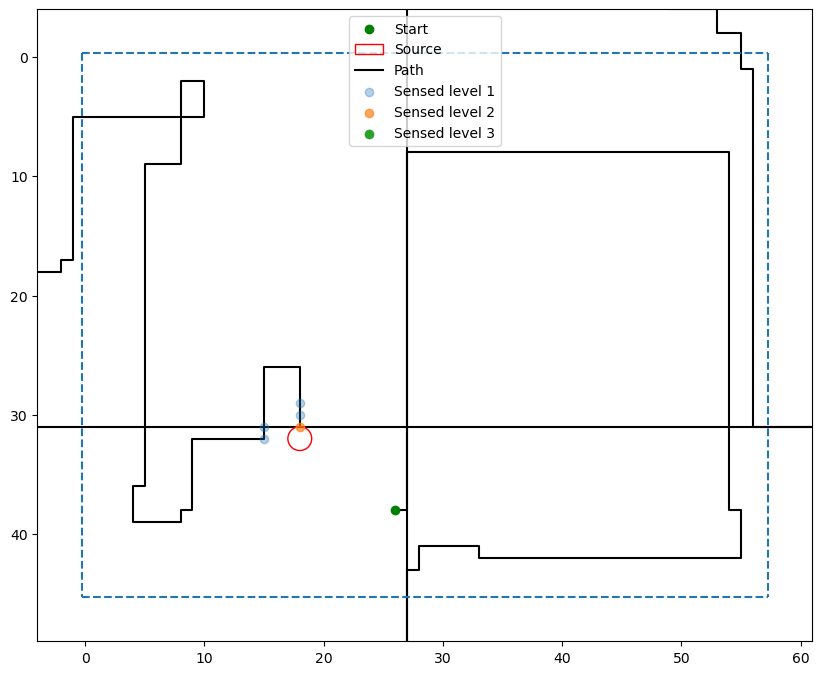

In [33]:
fig, ax = plt.subplots(figsize=(10,10))
plot_trajectory_in_tank(h = all_hist,
                        exp_agent = new_order_exp_agent_indices,
                        exp_source = new_order_exp_source_indices,
                        t_size = tank_size,
                        traj = 0,
                        ax = ax)

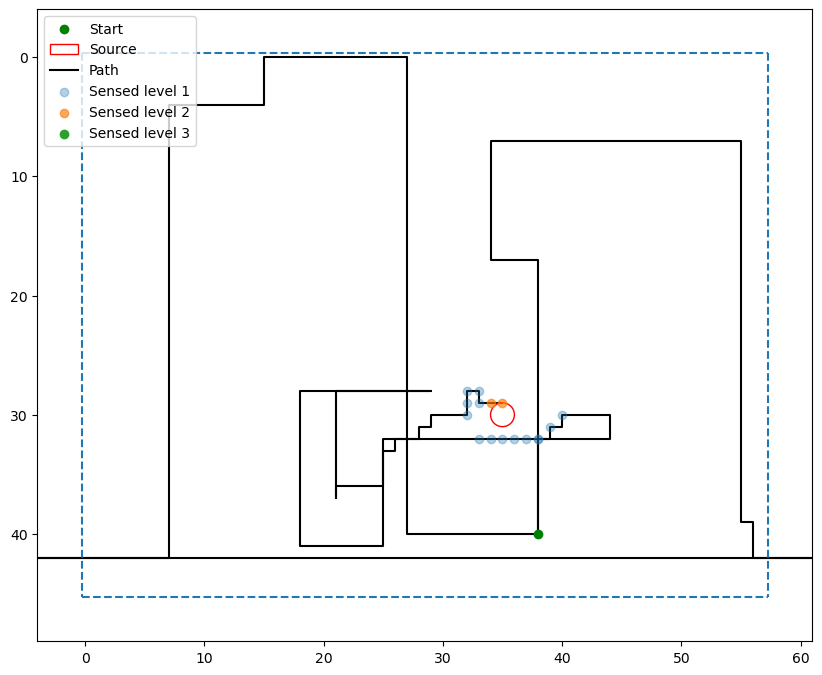

In [34]:
fig, ax = plt.subplots(figsize=(10,10))
plot_trajectory_in_tank(h = all_hist,
                        exp_agent = new_order_exp_agent_indices,
                        exp_source = new_order_exp_source_indices,
                        t_size = tank_size,
                        traj = 10,
                        ax = ax)

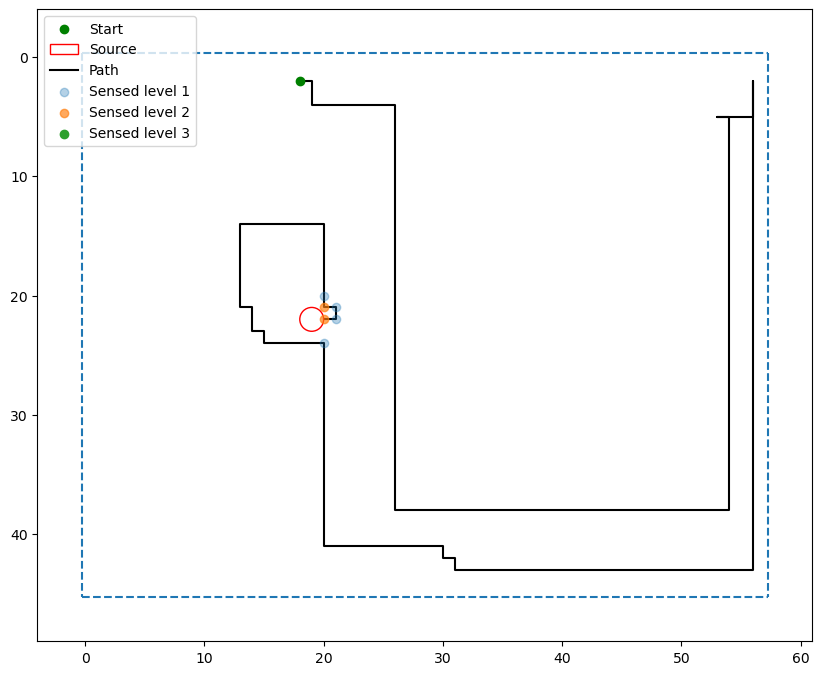

In [35]:
fig, ax = plt.subplots(figsize=(10,10))
plot_trajectory_in_tank(h = all_hist,
                        exp_agent = new_order_exp_agent_indices,
                        exp_source = new_order_exp_source_indices,
                        t_size = tank_size,
                        traj = 20,
                        ax = ax)

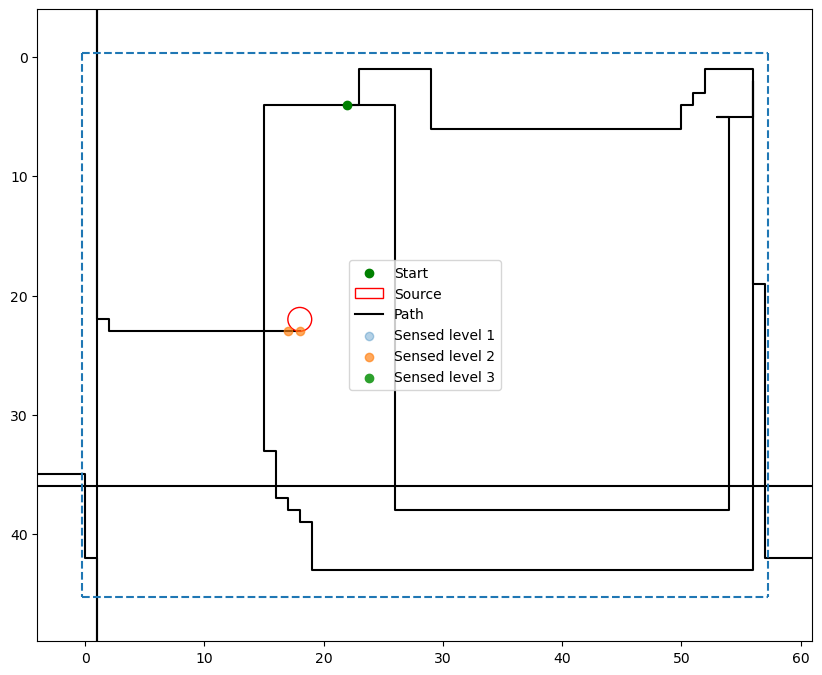

In [36]:
fig, ax = plt.subplots(figsize=(10,10))
plot_trajectory_in_tank(h = all_hist,
                        exp_agent = new_order_exp_agent_indices,
                        exp_source = new_order_exp_source_indices,
                        t_size = tank_size,
                        traj = 30,
                        ax = ax)

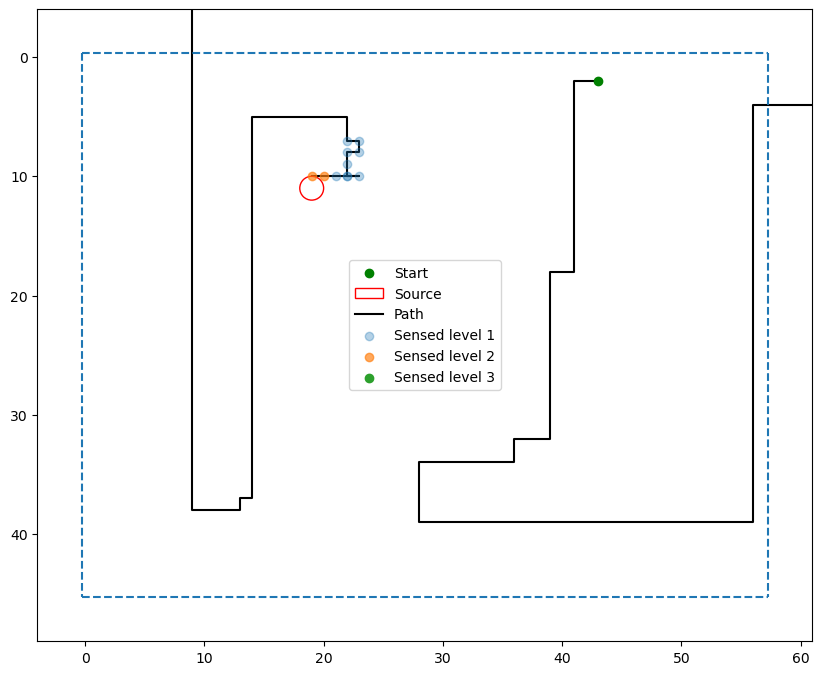

In [37]:
fig, ax = plt.subplots(figsize=(10,10))
plot_trajectory_in_tank(h = all_hist,
                        exp_agent = new_order_exp_agent_indices,
                        exp_source = new_order_exp_source_indices,
                        t_size = tank_size,
                        traj = 40,
                        ax = ax)

In [38]:
# Save all trajectories to folder
if not os.path.isdir(test_result_folder + 'trajectories/'):
    os.mkdir(test_result_folder + 'trajectories/')

for i in range(len(new_order_exp_agent_indices)):
    fig, ax = plt.subplots(figsize=(10,10))
    plot_trajectory_in_tank(h = all_hist,
                            exp_agent = new_order_exp_agent_indices,
                            exp_source = new_order_exp_source_indices,
                            t_size = tank_size,
                            traj = i,
                            ax = ax)

    plt.savefig(test_result_folder + 'trajectories/' + f'run-{i}.png')
    plt.close(fig)

### Plots

In [39]:
a_df = all_hist.analysis_df
runs_df = a_df[[str(i).startswith('run_') for i in a_df.index]]
success_runs_df = runs_df.loc[~runs_df['reached_horizon'].astype(bool)]

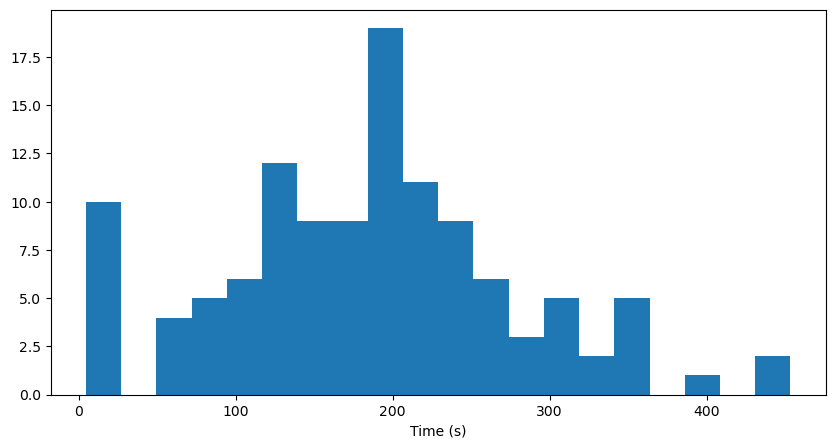

In [40]:
ax = (runs_df['steps_taken'] * dt).hist(grid=False, bins=20, figsize=(10,5))
ax.set_xlabel('Time (s)')
plt.savefig(test_result_folder + 'time_taken.png')
plt.show()

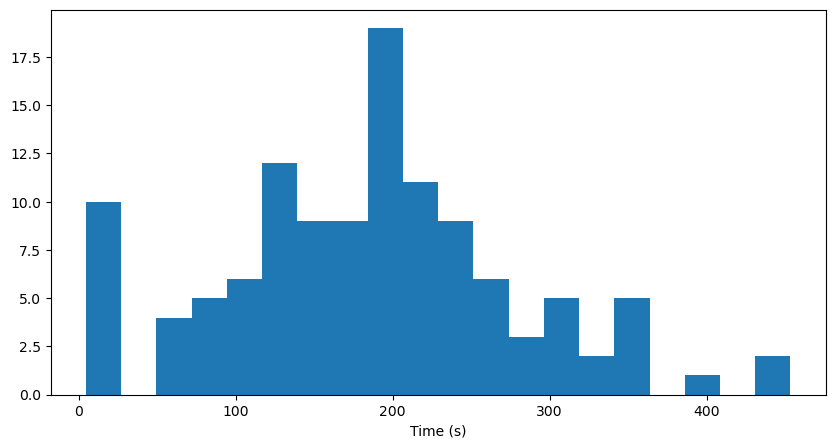

In [41]:
# Success only!
ax = (success_runs_df['steps_taken'] * dt).hist(grid=False, bins=20, figsize=(10,5))
ax.set_xlabel('Time (s)')
plt.savefig(test_result_folder + 'time_taken_success.png')
plt.show()

In [42]:
# Retrieving successes and speed from dataframe
successes = np.array(runs_df['converged'])
speed = np.array(runs_df['steps_taken'])

# Compute the grid to use
point_array = new_order_exp_source_indices # exp_agent_indices or exp_source_indices

grid = np.array([5,8])
cell_indices = np.array(list(np.ndindex(tuple(grid))))
cell_sizes = tank_size / grid

point_cell = (point_array / cell_sizes).astype(int)

# Compute successes and speeds in the grid
success_array = np.zeros(grid, dtype=float)
speed_array = np.zeros(grid, dtype=float)
count_array = np.zeros(grid, dtype=float)

for cell in cell_indices:
    point_in_cell = np.all(point_cell == cell, axis=1)
    count_in_cell = np.sum(point_in_cell)
    if count_in_cell == 0:
        continue

    success_perc = np.mean(successes[point_in_cell])
    average_speed = np.mean(speed[point_in_cell])

    success_array[*cell] = success_perc
    speed_array[*cell] = average_speed
    count_array[*cell] = count_in_cell

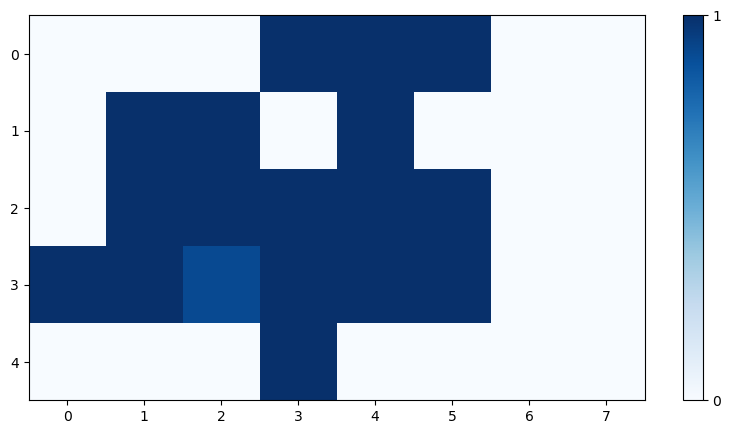

In [43]:
plt.figure(figsize=(10,5))
plt.imshow(success_array, cmap='Blues', vmin=0, vmax=1)
plt.colorbar(ticks=[0,1])
plt.savefig(test_result_folder + 'convergence_grid.png')
plt.show()

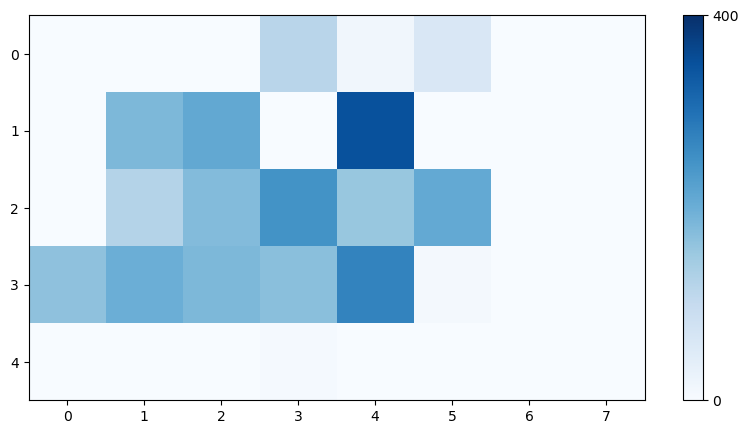

In [44]:
plt.figure(figsize=(10,5))
upper_bound = (np.ceil(np.max(speed_array * dt) / 100) * 100).astype(int)
plt.imshow(speed_array * dt, cmap='Blues', vmin=0, vmax=upper_bound)
plt.colorbar(ticks=[0,upper_bound])
plt.savefig(test_result_folder + 'time_taken_grid.png')
plt.show()